# Music playlist database

The project relies on the Chinook playlist database provided by Udacity. It answers three simple questions to show my proficiency in SQL for data mining. Here is the ERD of the database in order to understand how tables are joined to one another: 

In [1]:
# pip install sqlite3

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3


In [2]:
import sqlite3

In [4]:
import sqlite3

# Connect to the database
conn = sqlite3.connect('chinook.db')

# Create a cursor object
cur = conn.cursor()

# Execute a query to fetch table names
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch data
tables = cur.fetchall()

# Print the table names
for table in tables:
    print(table[0])

# Close the connection
conn.close()


Album
Artist
Customer
Employee
Genre
Invoice
InvoiceLine
MediaType
Playlist
PlaylistTrack
Track


## What are the three most preferred genres?


In [13]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('chinook.db')

# Define the SQL query
query = r"""
SELECT
  music_type,
  SUM(avg_total_sales) AS sum_avg_total_sales_by_genre,
  CASE
    WHEN SUM(avg_total_sales) >= 20 THEN 'Top'
    WHEN SUM(avg_total_sales) > 10 AND
         SUM(avg_total_sales) <= 20 THEN 'Medium'
    ELSE 'Low'
  END AS level_sales
FROM (SELECT DISTINCT
        Artist.Name AS artist_name,
        Genre.Name AS music_type,
        COUNT(Album.AlbumId) AS total_album,
        AVG(InvoiceLine.UnitPrice * InvoiceLine.Quantity) AS avg_total_sales
      FROM Artist
      JOIN Album
        ON Artist.ArtistId = Album.ArtistId
      JOIN Track
        ON Album.AlbumId = Track.AlbumId
      JOIN Genre
        ON Track.GenreId = Genre.GenreId
      JOIN InvoiceLine
        ON Track.TrackId = InvoiceLine.TrackId
      JOIN Invoice
        ON InvoiceLine.InvoiceId = Invoice.InvoiceId
      GROUP BY Artist.Name) sub
GROUP BY music_type
ORDER BY sum_avg_total_sales_by_genre DESC;
"""

# Execute the query and fetch data into a DataFrame
df = pd.read_sql_query(query, conn)

# Display the DataFrame
print(df)

# Close the connection
conn.close()


            music_type  sum_avg_total_sales_by_genre level_sales
0                 Rock                         47.52         Top
1            Classical                         32.67         Top
2                Latin                         23.76         Top
3   Alternative & Punk                         12.87      Medium
4                Metal                          9.90         Low
5                 Jazz                          6.93         Low
6             TV Shows                          5.97         Low
7                Drama                          3.98         Low
8                Blues                          3.96         Low
9                World                          2.97         Low
10            R&B/Soul                          2.97         Low
11         Alternative                          2.97         Low
12    Sci Fi & Fantasy                          1.99         Low
13              Reggae                          1.98         Low
14          Soundtrack   

We looked into the Chinook database to find out what was the volume of sales for each genre and found out what was the most important. It turns out that Rock is by far the most popular music with an average of 47.52 USD in the total of sales. 

It is almost 70 percent more than their second most profitable genre: Classical (32,67 USD average). The third most popular genre is Latin with 23,76 USD on average. 

It is an important insight in terms of sales and marketing efforts, the company can put more efforts and budget into the most popular genres to boost the sales. 

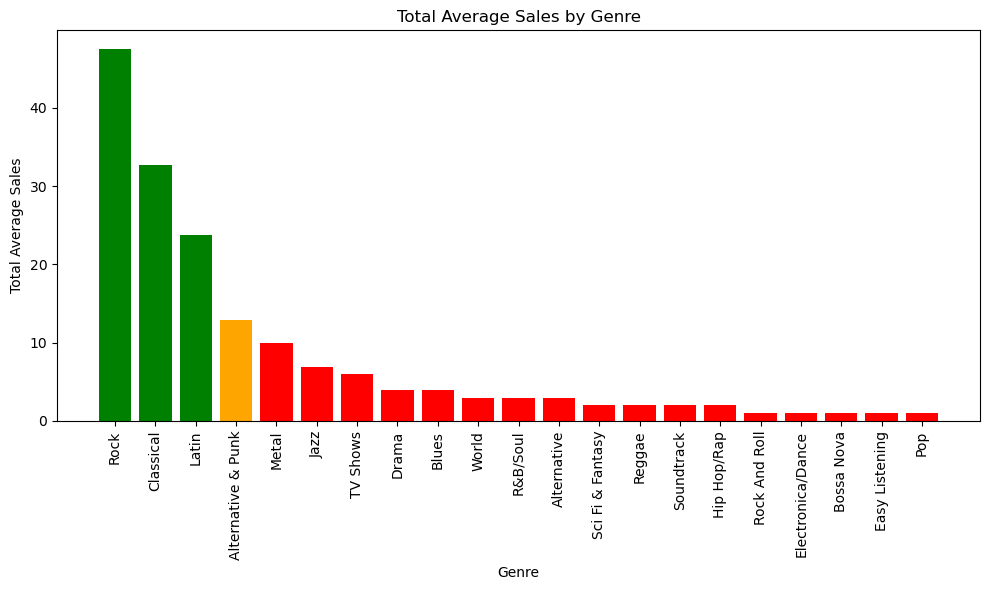

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
colors = {'Top': 'green', 'Medium': 'orange', 'Low': 'red'}
plt.bar(df['music_type'], df['sum_avg_total_sales_by_genre'], color=[colors[level] for level in df['level_sales']])
plt.xlabel('Genre')
plt.ylabel('Total Average Sales')
plt.title('Total Average Sales by Genre')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Which country was the best buyer in 2009?

In [15]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('chinook.db')

# Define the SQL query
query = r"""
SELECT

  Customer.Country,

  SUM(InvoiceLine.UnitPrice * InvoiceLine.Quantity) AS Total_sales

FROM Artist

JOIN Album

  ON Artist.ArtistId = Album.ArtistId

JOIN Track

  ON Album.AlbumId = Track.AlbumId

JOIN Genre

  ON Track.GenreId = Genre.GenreId

JOIN InvoiceLine

  ON Track.TrackId = InvoiceLine.TrackId

JOIN Invoice

  ON InvoiceLine.InvoiceId = Invoice.InvoiceId

JOIN Customer

  ON Invoice.CustomerId = Customer.CustomerId

WHERE Invoice.InvoiceDate BETWEEN '2009-01-01' AND '2009-12-26'

GROUP BY 1

ORDER BY 2 DESC;
"""

# Execute the query and fetch data into a DataFrame
df = pd.read_sql_query(query, conn)

# Display the DataFrame
print(df)

# Close the connection
conn.close()


           Country  Total_sales
0              USA       103.95
1           Canada        57.42
2          Germany        53.46
3           Brazil        37.62
4           France        34.65
5   United Kingdom        25.74
6           Poland        15.84
7            Chile        15.84
8         Portugal        11.88
9        Australia        11.88
10          Norway        10.89
11  Czech Republic        10.89
12           India         9.90
13     Netherlands         8.91
14         Finland         8.91
15         Ireland         6.93
16         Belgium         6.93
17          Sweden         5.94
18         Denmark         5.94
19           Italy         1.98
20         Austria         1.98
21           Spain         0.99


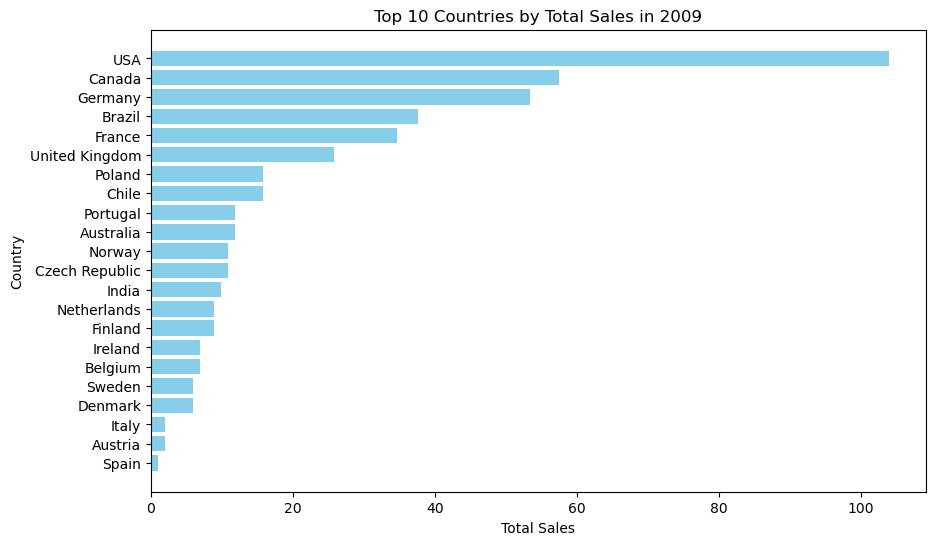

In [16]:
plt.figure(figsize=(10, 6))
plt.barh(df['Country'], df['Total_sales'], color='skyblue')
plt.xlabel('Total Sales')
plt.ylabel('Country')
plt.title('Top 10 Countries by Total Sales in 2009')
plt.gca().invert_yaxis()
plt.show()

Looking at the total sales in 2009 from our InvoiceLine database, it turns out that the United-States were far ahead in terms of turnover with 104 USD in total. It is 54,8 percent more than their second market, Canada (57 USD). It makes the USA a major market in 2009 in terms of sales. 

If the company wished to organize a concert with musics related to the 2000s, we can tell them that the USA, Canada and Germany should be the top 3 regions to put their marketing efforts. 

While the USA leads in total sales, countries such as Canada, Germany, Brazil, and France also demonstrate substantial total sales. This indicates that the music sold by the Chinook store has international appeal and attracts customers from various countries.

Countries with lower total sales, such as Portugal, Australia, Poland, and Chile, may represent untapped or emerging markets with growth potential. Understanding the factors influencing sales in these countries can help identify opportunities for expansion and market penetration.

## Which was the most popular album ever sold on the playlist?

In [20]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('chinook.db')

# Define the SQL query
query = r"""
SELECT
    Album.Title AS Album_Title,
    Artist.Name AS Artist_Name,
    Genre.Name AS Music_Genre,
    COUNT(InvoiceLine.InvoiceId) AS Total_Buy
FROM
    Artist
JOIN
    Album ON Artist.ArtistId = Album.ArtistId
JOIN
    Track ON Album.AlbumId = Track.AlbumId
JOIN
    Genre ON Track.GenreId = Genre.GenreId
JOIN
    InvoiceLine ON Track.TrackId = InvoiceLine.TrackId
JOIN
    Invoice ON InvoiceLine.InvoiceId = Invoice.InvoiceId
GROUP BY
    Album_Title, Artist_Name, Music_Genre
ORDER BY
    Total_Buy DESC
LIMIT 1;
"""

# Execute the query and fetch data into a DataFrame
df = pd.read_sql_query(query, conn)

# Display the DataFrame
print(df)

# Close the connection
conn.close()


      Album_Title    Artist_Name Music_Genre  Total_Buy
0  Minha Historia  Chico Buarque       Latin         27


## Who was the employee with the most buys and their favorite genre?

In [22]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('chinook.db')

# Define the SQL query
query = r"""
SELECT
    Employee.FirstName,
    Employee.LastName,
    Genre.Name AS Music_Type,
    SUM(InvoiceLine.UnitPrice * InvoiceLine.Quantity) AS Total_buy
FROM
    Employee
JOIN
    Customer ON Employee.EmployeeId = Customer.SupportRepId
JOIN
    Invoice ON Customer.CustomerId = Invoice.CustomerId
JOIN
    InvoiceLine ON Invoice.InvoiceId = InvoiceLine.InvoiceId
JOIN
    Track ON InvoiceLine.TrackId = Track.TrackId
JOIN
    Genre ON Track.GenreId = Genre.GenreId
GROUP BY
    Employee.FirstName,
    Employee.LastName,
    Genre.Name
ORDER BY
    Total_buy DESC
LIMIT 10;
"""

# Execute the query and fetch data into a DataFrame
df = pd.read_sql_query(query, conn)

# Display the DataFrame
print(df)

# Close the connection
conn.close()


  FirstName LastName          Music_Type  Total_buy
0      Jane  Peacock                Rock     300.96
1  Margaret     Park                Rock     297.00
2     Steve  Johnson                Rock     228.69
3      Jane  Peacock               Latin     137.61
4  Margaret     Park               Latin     126.72
5     Steve  Johnson               Latin     117.81
6  Margaret     Park               Metal      96.03
7     Steve  Johnson  Alternative & Punk      88.11
8      Jane  Peacock               Metal      85.14
9  Margaret     Park  Alternative & Punk      83.16


We asked if employees were also customers. It turns out that out of the 8 employees of the company, 3 (name on the bar charts) from the sales team bought different kind of music genres.

The top three sales were for rock music and Jane Peacock was the employee with the most buys with $ 301 in this music genre.

If the company was to start an internal communication campaign, these employees could be rewarded with some kind of free pass to buy a rock album of their choice for free for instance.

### Customer Lifetime Value (CLV)

In [25]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('chinook.db')

# Define the SQL query
query = r"""
SELECT
    c.CustomerId,
    c.FirstName || ' ' || c.LastName AS CustomerName,
    COUNT(DISTINCT i.InvoiceId) AS TotalTransactions,
    SUM(i.Total) AS TotalPurchases,
    (SUM(i.Total) / COUNT(DISTINCT i.InvoiceDate)) AS CLV
FROM
    Customer c
JOIN
    Invoice i ON c.CustomerId = i.CustomerId
GROUP BY
    c.CustomerId,
    CustomerName
ORDER BY
    CLV DESC;
"""

# Execute the query and fetch data into a DataFrame
df = pd.read_sql_query(query, conn)

# Display the DataFrame
print(df)

# Close the connection
conn.close()


    CustomerId           CustomerName  TotalTransactions  TotalPurchases  \
0            6            Helena Holý                  7           49.62   
1           26     Richard Cunningham                  7           47.62   
2           57             Luis Rojas                  7           46.62   
3           45        Ladislav Kovács                  7           45.62   
4           46          Hugh O'Reilly                  7           45.62   
5           28          Julia Barnett                  7           43.62   
6           24          Frank Ralston                  7           43.62   
7           37        Fynn Zimmermann                  7           43.62   
8           59        Puja Srivastava                  6           36.64   
9            7          Astrid Gruber                  7           42.62   
10          25         Victor Stevens                  7           42.62   
11          44       Terhi Hämäläinen                  7           41.62   
12          

Customers with higher CLV values are those who have made more purchases over time. These customers are likely to be loyal and contribute significantly to the business's revenue. 

